In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import h5py
from PIL import Image
import io
import pandas as pd
from load_utils import byte_string_to_resized_image_array, load_image_from_hdf5

In [2]:
# Load Metadata
metadata = pd.read_csv('metadata.csv')
hdf5_file = 'train-image.hdf5'

# Separate isic_ids based on target class 
malignant_ids = metadata[metadata['target'] == 1]['isic_id'].values
benign_ids = metadata[metadata['target'] == 0]['isic_id'].values

In [3]:
# Image Generator for benign images
benign_datagen = ImageDataGenerator(rescale=1./255)

# Image Generator for malignant images
malignant_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    rescale=1./255
)

In [7]:
def data_generator(metadata, benign_ids, malignant_ids, hdf5_file, batch_size=32, target_size=(128, 128), malignant_augment_limit=4000):
    benign_count = 0
    malignant_count = 0
    tot_malignant_count = 0
    
    while True:
        images = []
        labels = []
        
        for index, row in metadata.iterrows():
            isic_id = row['isic_id']
            target = row['target']  # Binary label
            
            # Load image based on isic_id
            image_array = load_image_from_hdf5(isic_id, hdf5_file)
            
            # Apply augmentation for malignant cases
            if isic_id in malignant_ids:
                if malignant_count < malignant_augment_limit:  # Augment only until the limit is reached
                    augmented_image = malignant_datagen.random_transform(image_array)  # Augmentation
                    images.append(augmented_image)
                    labels.append(1)  # Malignant label
                    malignant_count += 1  # Keep track of augmented malignant samples
                    tot_malignant_count += 1
                    
                     # Append new row to metadata for each augmented sample
                    augmented_row = row.copy()
                    augmented_row['isic_id'] = f"{isic_id}_aug_{malignant_count}"  # Create unique ID for augmented sample
                    metadata = metadata.append(augmented_row, ignore_index=True)
       
                else:
                    # After reaching the limit, continue but don't augment malignant images
                    standardized_image = malignant_datagen.standardize(image_array)  # Just standardize after the limit
                    images.append(standardized_image)
                    labels.append(1)  # Still malignant label
                    tot_malignant_count += 1

            # Process benign cases without augmentation
            elif isic_id in benign_ids:
                benign_image = benign_datagen.standardize(image_array)  # Standardize without augmentation
                images.append(benign_image)
                labels.append(0)  # Benign label
                benign_count += 1
            
            # Yield the batch when enough samples are collected
            if len(images) == batch_size:
                print(f"Benign samples processed: {benign_count}, Malignant samples augmented: {malignant_count}, Total Malignant samples: {tot_malignant_count}")
                yield np.array(images), np.array(labels)
                images = []  # Reset for the next batch
                labels = []
        
        # Optional: print the final counts of benign and malignant samples processed
        print(f"Total Benign samples processed: {benign_count}, Malignant samples augmented: {malignant_count}, Total Malignant samples: {tot_malignant_count}")


In [8]:
metadata_subset = metadata.head(1000)  # Load the first 1000 rows
generator = data_generator(metadata_subset, benign_ids, malignant_ids, hdf5_file, batch_size=32)

# Test a few iterations
for i in range(3):
    images, labels = next(generator)
    print(f"Batch {i+1} - Image shape: {images.shape}, Labels shape: {labels.shape}")


Benign samples processed: 32, Malignant samples augmented: 0, Total Malignant samples: 0
Batch 1 - Image shape: (32, 128, 128, 3), Labels shape: (32,)
Benign samples processed: 64, Malignant samples augmented: 0, Total Malignant samples: 0
Batch 2 - Image shape: (32, 128, 128, 3), Labels shape: (32,)
Benign samples processed: 96, Malignant samples augmented: 0, Total Malignant samples: 0
Batch 3 - Image shape: (32, 128, 128, 3), Labels shape: (32,)


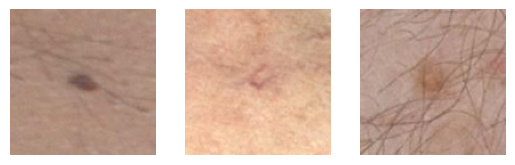

In [9]:
import matplotlib.pyplot as plt

# Reshape the images to (128, 128, 3) if necessary
reshaped_images = images.reshape(-1, 128, 128, 3)

# Plot the first three images
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(reshaped_images[i])
    plt.axis('off')
plt.savefig('plots/sample_images.png')
plt.show()